# Chapter 07 앙상블 학습과 랜덤 포레스트

In [37]:
# 기본설정

# 파이썬 버전 확인
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 버전 확인
import sklearn
assert sklearn.__version__ >= "0.20"

# 공동 모듈 임포트
import numpy as np
import os

# 그래프 출력 설정
%matplotlib inline
# 위에꺼는 구버전에서 설정해야 되는거였음 설정안해도됨
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ho_chap_07"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)   # exist_ok=True 폴더가 없으면 생성

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()  # 입력없이 사용할 경우 기존에 세팅된 기본값으로 자동 레이아웃 설정
    plt.savefig(path, format=fig_extension, dpi=resolution)  # dpi값 설정을 통해 고해상도 그래프 그리기 가능

## 7.1 투표 기반 분류기
* 앙상블 방법은 예측기가 서로 독립적일 때 최고의 성능을 발휘

In [21]:
# 데이터 받아오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
# 투표기반 분류기
# 분류 모델 받아오기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

# 직접투표
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [28]:
# 각 분류기 정확도
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.904


In [29]:
# 간접투표
# 모든 분류기가 predict_proba 함수를 가져야함
from sklearn.neighbors import KNeighborsClassifier

svm_clf = SVC(probability=True)  # 모델 생성시 pro 를 True로 해줘야 predict_proba 함수를 사용가능

voting_clf_s = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf_s.fit(X_train, y_train)

y_pred = voting_clf_s.predict(X_test)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

VotingClassifier 0.912


간접투표에서 조금 더 성능이 좋게 나옴

## 7.2 배깅과 페이스팅
* 중복을 허용한 샘플링을 배깅
* 중복을 허용하지 않는 샘플링을 페이스팅
* 앙상블을 활용하면 원본 데이터셋으로 하나의 예측기를 훈련시킬떄와 비교해 편향은 비슷하지만 분산은 줄어듬
* 병렬 학습이 가능해 인기가 많음

In [31]:
# 배깅
from sklearn.ensemble import BaggingClassifier # predict_proba() 함수가 있으면 자동으로 간접 두표 방식을 사용
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


In [32]:
# 일반 트리
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [33]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


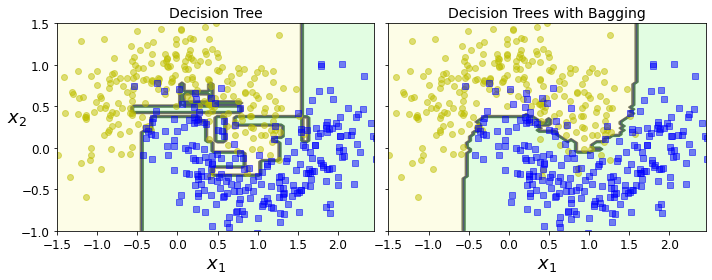

In [38]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

앙상블에서 더 작은 분산을 만들어 일반화가 잘된걸 볼 수 있음.

In [39]:
#페이스팅

pas_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1)
pas_clf.fit(X_train, y_train)
y_pred = pas_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.92


그림 저장: decision_tree_without_and_with_pasting_plot


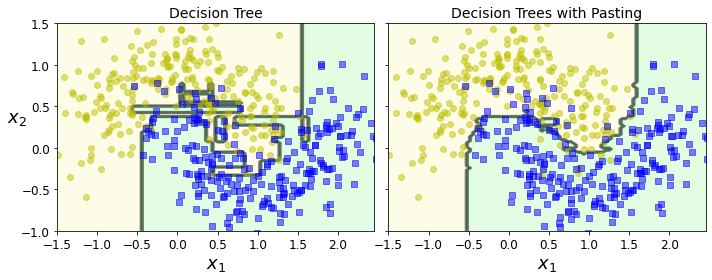

In [41]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(pas_clf, X, y)
plt.title("Decision Trees with Pasting", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_pasting_plot")
plt.show()

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음<br/>
But 다양성을 추가하면 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴.<br/>
일반적으로 배깅이 더 좋음

### 7.2.2 obb 평가
* m개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 
$ (1-\frac{1}{m})^m $
* 여기에 로그를 취하고 로피탈의 정리를 적용하면 $e^-1$과 같아짐
* 따라서 선택되지 않을 확률은 위 값을 1에 뺀 값인 0.63212와 같음
* 선택되지 않은 37%를 oob(out-of-bag)이라고 함

In [44]:
# oob평가 점수
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

In [45]:
# 실제 정확도
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

In [47]:
# oob 샘플에 대한 결정 함수값
bag_clf.oob_decision_function_[:5]

array([[0.39086294, 0.60913706],
       [0.38586957, 0.61413043],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.00543478, 0.99456522]])

## 7.3 랜덤 패치와 랜덤 서브스페이스
* BaggingCla-는 max_features, bootstrap_features 를 통한 특성 샘플링 지원
* 훈련 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치 방식
* 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것을 랜덤 서브스페이스 방식
* 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리는 대신 분산을 낮춤

In [ ]:
# 